In [2]:
import pandas as pd

# Load the dataset
file_path = "/Users/rachanathotireddy/Desktop/Project/Feature_data.csv"  # Update this with your actual file path
df = pd.read_csv(file_path)

# 1. Convert to simple ratio (overall homeless / total population)
ratio_columns = [
    "overall_homeless",
    "drug_overdose_deaths",
    "total_vacant_units",
    "totalsubsidized_units"
]

# Calculate ratio by dividing each column by the population & round to 2 decimal places
for col in ratio_columns:
    df[col + "_per_capita"] = (df[col] / df["population"]).round(4)

# Drop the original absolute value columns
df.drop(columns=ratio_columns, inplace=True)


# Create 1-year lagged version of Median_Rent
df["Median_Rent_lag1"] = df.groupby("state")["Median_Rent"].shift(1)

# Optional: Drop rows with missing lag values (if needed for modeling)
df = df.dropna(subset=["Median_Rent_lag1"])


# Save the updated dataset
df.to_csv("/Users/rachanathotireddy/Desktop/Project/Feature_Data_Engineered.csv", index=False)

#  Display confirmation message
print("\n Feature-engineered dataset saved successfully: 'Feature_Data_Engineered.csv'")



 Feature-engineered dataset saved successfully: 'Feature_Data_Engineered.csv'


In [4]:
import pandas as pd

# Load the dataset
file_path = "/Users/rachanathotireddy/Desktop/Project/Feature_Data_Engineered.csv"
df = pd.read_csv(file_path)


# Check for Duplicates

duplicate_rows = df[df.duplicated()]
duplicate_count = duplicate_rows.shape[0]

print(f"\n Duplicate Rows Found: {duplicate_count}")
if duplicate_count > 0:
    print(duplicate_rows.head())

# -----------------------------
# ❓ 2. Check for Missing Values
# -----------------------------
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("\n❓ Missing Values Summary:")
print(missing_values)

# -----------------------------
# 🧾 3. Formatting Issues in Object Columns
# -----------------------------
object_columns = df.select_dtypes(include='object').columns.tolist()

print("\n🧾 Object Columns & Sample Values (Check for commas or unexpected strings):")
for col in object_columns:
    print(f"\n🔍 Column: {col}")
    print(df[col].dropna().astype(str).unique()[:5])  # Show up to 5 unique values



 Duplicate Rows Found: 0

❓ Missing Values Summary:
annual_median_wage                  50
hourly_median_wage                  50
poverty_rate                       100
total_households                   100
opioid_overdose                    101
total_occupied_housing             100
owner_occupied_housing             100
vacant_for_rent                    150
rented_not_occupied                150
vacant_for_sale                    150
sold_not_occupied                  150
other_vacant_units                 150
Median_Rent                         17
median_household_income            400
drug_overdose_deaths_per_capita    100
total_vacant_units_per_capita      150
dtype: int64

🧾 Object Columns & Sample Values (Check for commas or unexpected strings):

🔍 Column: state
['Alaska' 'Alabama' 'Arkansas' 'Arizona' 'California']

🔍 Column: opioid_overdose
['66' '176' '169' '562' '1938']


In [6]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = "/Users/rachanathotireddy/Desktop/Project/Feature_Data_Engineered.csv"
df = pd.read_csv(file_path)

# Convert 'opioid_overdose' to numeric (removes commas & ensures correct type)
df["opioid_overdose"] = df["opioid_overdose"].astype(str).str.replace(",", "").replace("nan", np.nan)
df["opioid_overdose"] = pd.to_numeric(df["opioid_overdose"], errors="coerce")

# Ensure all object columns that should be numeric are converted
for col in df.select_dtypes(include='object').columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass  # If conversion fails, leave the column as is

cleaned_path = "/Users/rachanathotireddy/Desktop/Project/Feature_Data_Engineered.csv"
df.to_csv(cleaned_path, index=False)

print(f"Formatting cleaned without warnings. Missing values remain unchanged. Data saved to: {cleaned_path}")


Formatting cleaned without warnings. Missing values remain unchanged. Data saved to: /Users/rachanathotireddy/Desktop/Project/Feature_Data_Engineered.csv


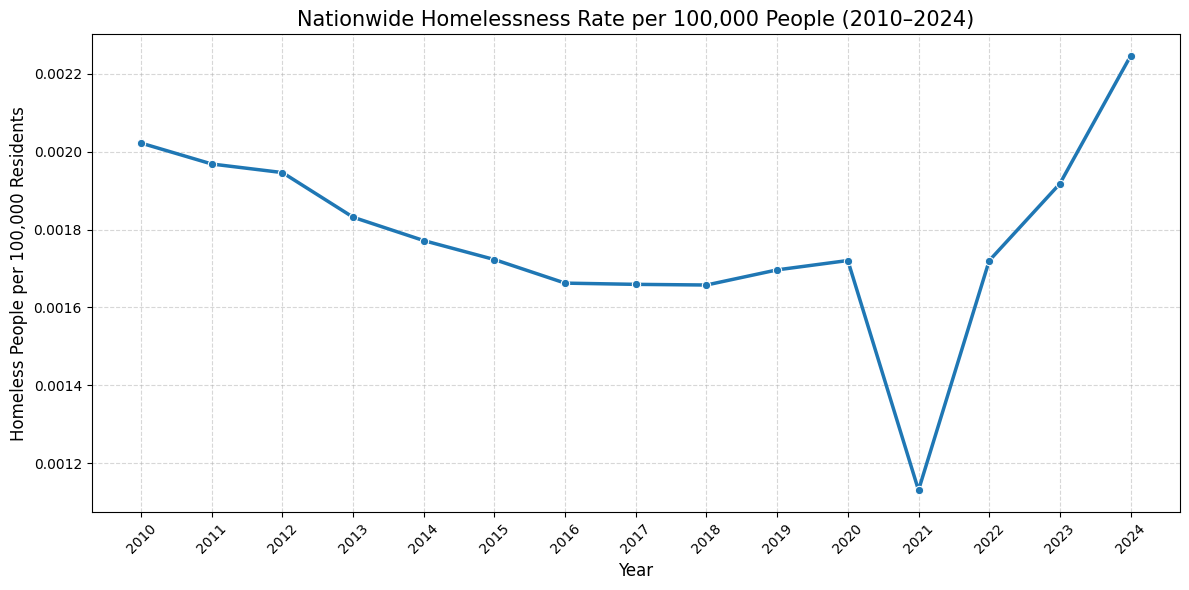

 Plot saved to: /Users/rachanathotireddy/Desktop/Project/Plots/nationwide_homeless_per_capita_trend_from_raw_counts.png


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataset
file_path = "/Users/rachanathotireddy/Desktop/Project/Homelessness_Data copy 2.csv"
df = pd.read_csv(file_path)

# Create folder to save plots
plot_dir = "/Users/rachanathotireddy/Desktop/Project/Plots"
os.makedirs(plot_dir, exist_ok=True)

# Step 1: Group by year to get national totals
national = df.groupby("year").agg({
    "overall homeless": "sum",
    "population": "sum"
}).reset_index()

# Step 2: Compute per 100,000 metric
national["ratio"] = (national["overall homeless"] / national["population"]) 

# Step 3: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=national, x="year", y="ratio", marker="o", linewidth=2.5)
plt.title("Nationwide Homelessness Rate per 100,000 People (2010–2024)", fontsize=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Homeless People per 100,000 Residents", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(national["year"], rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()

# Step 4: Save the plot
save_path = f"{plot_dir}/nationwide_homeless_per_capita_trend_from_raw_counts.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f" Plot saved to: {save_path}")


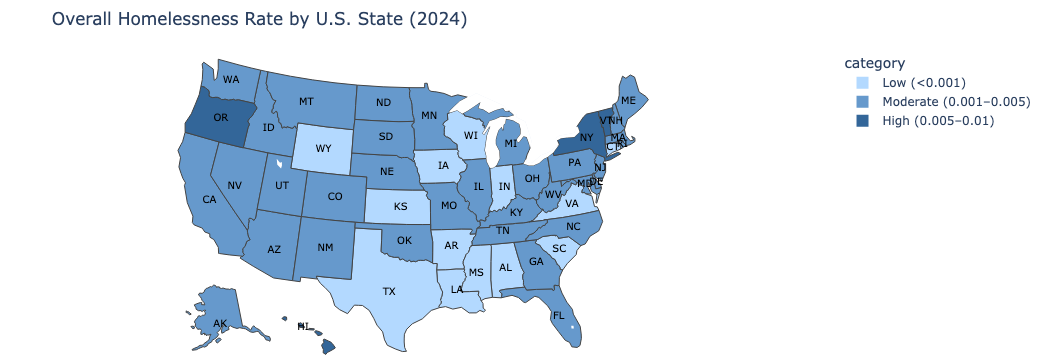

Plot saved to: /Users/rachanathotireddy/Desktop/Project/Plots/homelessness_map_2024.png


In [12]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Define state abbreviations with latitude & longitude
state_info = {
    'Alabama': ('AL', 32.8, -86.8), 'Alaska': ('AK', 61.4, -152.4), 'Arizona': ('AZ', 33.7, -111.4),
    'Arkansas': ('AR', 35.0, -92.4), 'California': ('CA', 36.8, -119.4), 'Colorado': ('CO', 39.0, -105.5),
    'Connecticut': ('CT', 41.6, -72.7), 'Delaware': ('DE', 39.0, -75.5), 'Florida': ('FL', 28.0, -82.0),
    'Georgia': ('GA', 33.0, -83.5), 'Hawaii': ('HI', 21.3, -157.8), 'Idaho': ('ID', 44.1, -114.5),
    'Illinois': ('IL', 40.0, -89.0), 'Indiana': ('IN', 39.8, -86.0), 'Iowa': ('IA', 42.0, -93.0),
    'Kansas': ('KS', 38.5, -98.0), 'Kentucky': ('KY', 37.5, -85.0), 'Louisiana': ('LA', 31.2, -92.0),
    'Maine': ('ME', 45.2, -69.4), 'Maryland': ('MD', 39.0, -76.8), 'Massachusetts': ('MA', 42.3, -71.8),
    'Michigan': ('MI', 43.5, -84.7), 'Minnesota': ('MN', 46.4, -94.6), 'Mississippi': ('MS', 32.6, -89.9),
    'Missouri': ('MO', 38.5, -92.5), 'Montana': ('MT', 46.9, -110.4), 'Nebraska': ('NE', 41.5, -99.7),
    'Nevada': ('NV', 38.5, -117.0), 'New Hampshire': ('NH', 43.8, -71.6), 'New Jersey': ('NJ', 40.1, -74.7),
    'New Mexico': ('NM', 34.5, -106.0), 'New York': ('NY', 42.9, -75.5), 'North Carolina': ('NC', 35.5, -79.0),
    'North Dakota': ('ND', 47.5, -100.5), 'Ohio': ('OH', 40.2, -82.7), 'Oklahoma': ('OK', 35.5, -97.5),
    'Oregon': ('OR', 44.0, -120.5), 'Pennsylvania': ('PA', 41.0, -77.5), 'Rhode Island': ('RI', 41.7, -71.5),
    'South Carolina': ('SC', 33.8, -80.9), 'South Dakota': ('SD', 44.5, -100.0), 'Tennessee': ('TN', 36.0, -86.7),
    'Texas': ('TX', 31.0, -99.0), 'Utah': ('UT', 39.3, -111.7), 'Vermont': ('VT', 44.0, -72.7),
    'Virginia': ('VA', 37.5, -78.7), 'Washington': ('WA', 47.5, -120.5), 'West Virginia': ('WV', 38.6, -80.6),
    'Wisconsin': ('WI', 44.5, -89.5), 'Wyoming': ('WY', 43.0, -107.5), 'District Of Columbia': ('DC', 38.9, -77.0)
}

# Load dataset
df = pd.read_csv("/Users/rachanathotireddy/Desktop/Project/Feature_Data_Engineered.csv")

df_2024 = df[df["year"] == 2024].copy()

# Assign state abbreviation, latitude, and longitude
df_2024["state_abbrev"] = df_2024["state"].map(lambda x: state_info[x][0] if x in state_info else None)
df_2024["lat"] = df_2024["state"].map(lambda x: state_info[x][1] if x in state_info else None)
df_2024["lon"] = df_2024["state"].map(lambda x: state_info[x][2] if x in state_info else None)

# Remove rows where lat/lon are missing
df_2024 = df_2024.dropna(subset=["lat", "lon"])

# Categorize homelessness per capita (calculated ratio for homelessness)
df_2024["category"] = df_2024["overall_homeless_per_capita"].apply(
    lambda x: "Low (<0.001)" if x < 0.001 else "Moderate (0.001–0.005)" if x < 0.005 else "High (0.005–0.01)" if x < 0.01 else "Very High (>0.01)"
)

# Define color mapping for the categories
color_scale = {
    "Low (<0.001)": "#b3d9ff",  # Light blue
    "Moderate (0.001–0.005)": "#6699cc",  # Medium blue
    "High (0.005–0.01)": "#336699",  # Darker blue
    "Very High (>0.01)": "#1a3d66"  # Darkest blue
}

# Create choropleth map with proper categories
fig = px.choropleth(
    df_2024,
    locations="state_abbrev",  
    locationmode="USA-states",
    scope="usa",
    color="category",
    color_discrete_map=color_scale,
    title="Overall Homelessness Rate by U.S. State (2024)",
    category_orders={"category": ["Low (<0.001)", "Moderate (0.001–0.005)", "High (0.005–0.01)", "Very High (>0.01)"]}
)

# Adding state abbreviations on the map
fig.add_trace(go.Scattergeo(
    lon=df_2024["lon"],
    lat=df_2024["lat"],
    text=df_2024["state_abbrev"],
    mode="text",
    textfont=dict(color="black", size=10),
    showlegend=False
))

fig.update_layout(
    geo=dict(scope="usa", showlakes=True, lakecolor="white"),
    margin={"r": 0, "t": 50, "l": 0, "b": 0}
)

fig.show()

save_path = "/Users/rachanathotireddy/Desktop/Project/Plots/homelessness_map_2024.png"
fig.write_image(save_path, scale=3)

print(f"Plot saved to: {save_path}")


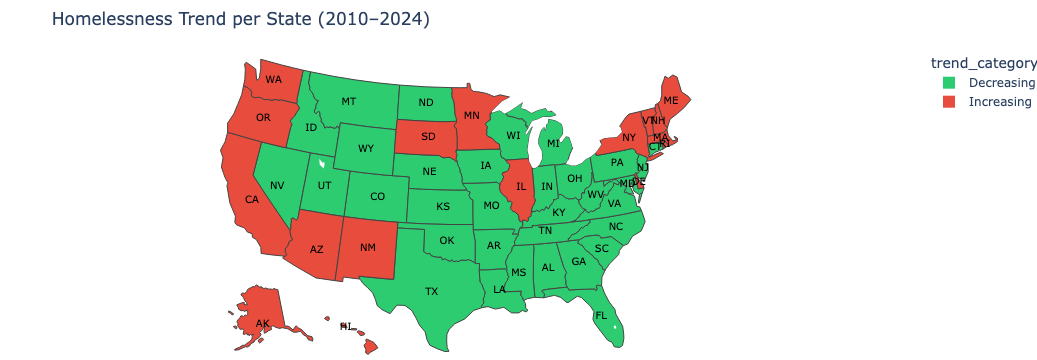

✅ Plot saved to: /Users/rachanathotireddy/Desktop/Project/Plots/homelessness_trend_per_state.png


In [14]:
from numpy import polyfit
import plotly.graph_objects as go
import plotly.express as px

# Filter data from 2010 to 2024 and calculate the trend (slope) for each state
df_trend = df[df["year"].between(2010, 2024)].copy()

# Calculate the slope for each state
state_trends = (
    df_trend.groupby("state")
    .apply(lambda x: polyfit(x["year"], x["overall_homeless_per_capita"], 1)[0])  # Change to "overall_homeless_ratio"
    .reset_index(name="homelessness_slope")
)

# Merge lat/lon info
state_trends["state_abbrev"] = state_trends["state"].map(lambda x: state_info[x][0] if x in state_info else None)
state_trends["lat"] = state_trends["state"].map(lambda x: state_info[x][1] if x in state_info else None)
state_trends["lon"] = state_trends["state"].map(lambda x: state_info[x][2] if x in state_info else None)

# Drop rows where lat/lon are missing
state_trends.dropna(subset=["lat", "lon"], inplace=True)

# Categorize slope
state_trends["trend_category"] = state_trends["homelessness_slope"].apply(
    lambda x: "Increasing" if x > 0 else "Decreasing" if x < 0 else "Stable"
)

# Define color mapping
trend_colors = {"Increasing": "#e74c3c", "Decreasing": "#2ecc71", "Stable": "#f1c40f"}

# Plot the choropleth map
fig = px.choropleth(
    state_trends,
    locations="state_abbrev",
    locationmode="USA-states",
    scope="usa",
    color="trend_category",
    color_discrete_map=trend_colors,
    title="Homelessness Trend per State (2010–2024)"
)

# Add state abbreviations on the map
fig.add_trace(go.Scattergeo(
    lon=state_trends["lon"],
    lat=state_trends["lat"],
    text=state_trends["state_abbrev"],
    mode="text",
    textfont=dict(color="black", size=10),
    showlegend=False
))

fig.update_layout(
    geo=dict(scope="usa", showlakes=True, lakecolor="white"),
    margin={"r": 0, "t": 50, "l": 0, "b": 0}
)

# Save the Plotly plot as an image
save_path = "/Users/rachanathotireddy/Desktop/Project/Plots/homelessness_trend_per_state.png"
fig.write_image(save_path, scale=3)
fig.show()

print(f"✅ Plot saved to: {save_path}")


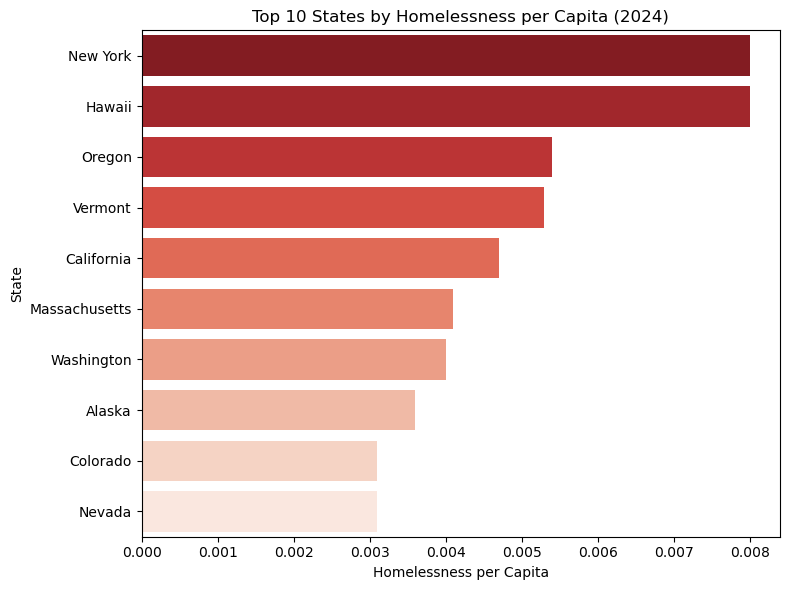

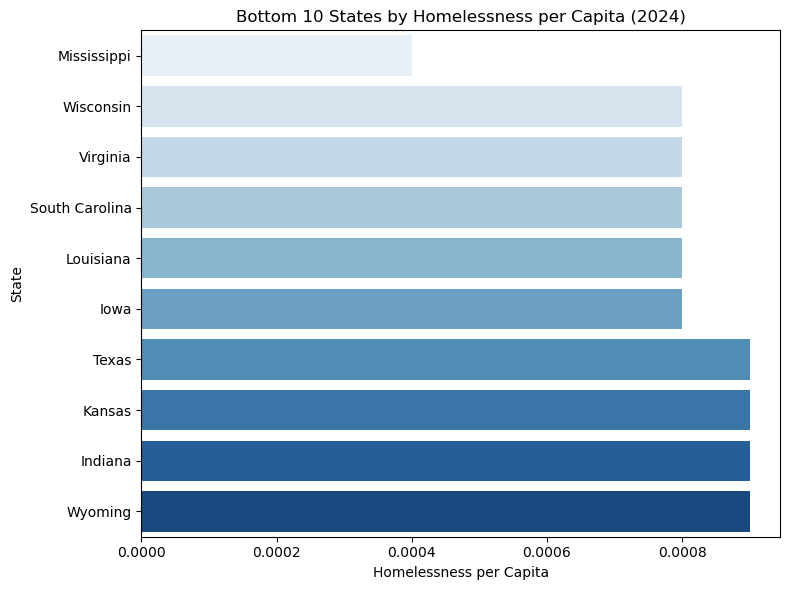

✅ Plots saved as /Users/rachanathotireddy/Desktop/Project/Plots/homelesnesspercapita1.png and /Users/rachanathotireddy/Desktop/Project/Plots/homelesnesspercapita.png


In [190]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming top_10 and bottom_10 are already defined
# Sort the dataframe based on the "overall_homeless_ratio"
top_10 = df_2024.sort_values(by="overall_homeless_per_capita", ascending=False).head(10)
bottom_10 = df_2024.sort_values(by="overall_homeless_per_capita", ascending=True).head(10)

# Top 10 States Only
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_10,
    x="overall_homeless_per_capita",
    y="state",
    hue="state",  
    palette="Reds_r",
    legend=False  # Disable the legend since it's not necessary for this plot
)
plt.title("Top 10 States by Homelessness per Capita (2024)")
plt.xlabel("Homelessness per Capita")
plt.ylabel("State")
plt.tight_layout()
save_path_top = "/Users/rachanathotireddy/Desktop/Project/Plots/homelesnesspercapita1.png"
plt.savefig(save_path_top, dpi=300)
plt.show()

# Bottom 10 States Only
plt.figure(figsize=(8, 6))
sns.barplot(
    data=bottom_10,
    x="overall_homeless_per_capita",
    y="state",
    hue="state",  # Assign "state" to hue to avoid the FutureWarning
    palette="Blues",
    legend=False  # Disable the legend since it's not necessary for this plot
)
plt.title("Bottom 10 States by Homelessness per Capita (2024)")
plt.xlabel("Homelessness per Capita")
plt.ylabel("State")
plt.tight_layout()
save_path_bottom = "/Users/rachanathotireddy/Desktop/Project/Plots/homelesnesspercapita.png"
plt.savefig(save_path_bottom, dpi=300)
plt.show()

print(f"Plots saved as {save_path_top} and {save_path_bottom}")


Pearson Correlation: -0.11 (p-value: 0.4679)

States with Both High Median Rent AND High Homelessness Per 100K in 2023:
        state  Median_Rent  overall_homeless_per_capita
     New York       1341.0                       0.0052
      Vermont        961.0                       0.0051
       Oregon       1180.0                       0.0047
        Maine        920.0                       0.0030
      Arizona        959.0                       0.0019
New Hampshire       1124.0                       0.0017
 Rhode Island       1276.0                       0.0016
 South Dakota       1253.0                       0.0014
    Tennessee       1209.0                       0.0013
        Idaho       1209.0                       0.0012
     Nebraska       1077.0                       0.0012


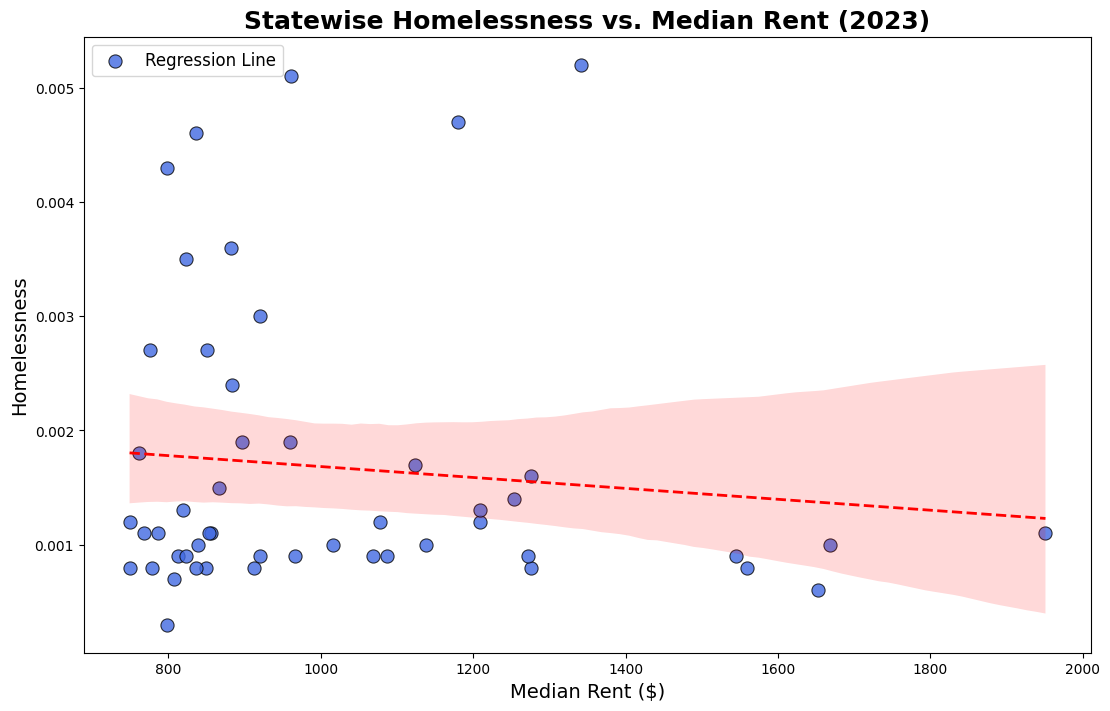

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# Load dataset
file_path = "/Users/rachanathotireddy/Desktop/Project/Feature_Data_Engineered.csv"
df = pd.read_csv(file_path)

#  Filter for only 2023 data
df = df[df["year"] == 2023]

# 🔍 Check required columns
required_columns = {"Median_Rent", "overall_homeless_per_capita", "state"}
missing_cols = required_columns - set(df.columns)
if missing_cols:
    raise ValueError(f"Missing columns from dataset: {missing_cols}")

# Compute Pearson Correlation (Show in output, not on graph)
correlation, p_value = stats.pearsonr(df["Median_Rent"], df["overall_homeless_per_capita"])
print(f"Pearson Correlation: {correlation:.2f} (p-value: {p_value:.4f})")

# Compute Median Values for Filtering
median_rent = df["Median_Rent"].median()
median_homelessness = df["overall_homeless_per_capita"].median()

high_rent_high_homeless = df[
    (df["Median_Rent"] > median_rent) & 
    (df["overall_homeless_per_capita"] > median_homelessness)
][["state", "Median_Rent", "overall_homeless_per_capita"]].sort_values(by="overall_homeless_per_capita", ascending=False)

# Print the filtered states
print("\nStates with Both High Median Rent AND High Homelessness Per 100K in 2023:")
print(high_rent_high_homeless.to_string(index=False))

# 📌 **Scatter Plot**
plt.figure(figsize=(13, 8))

#  Scatter plot with a **single** professional color
sns.scatterplot(
    data=df, 
    x="Median_Rent", 
    y="overall_homeless_per_capita", 
    color="royalblue", 
    edgecolor="black", 
    s=90, 
    alpha=0.8
)

# Add regression trend line **without confidence interval**
sns.regplot(
    data=df, 
    x="Median_Rent", 
    y="overall_homeless_per_capita",  
    scatter=False,  # No additional scatter overlay
    line_kws={"color": "red", "linestyle": "--", "linewidth": 2}
)

#  Titles & Labels
plt.title("Statewise Homelessness vs. Median Rent (2023)", fontsize=18, weight="bold")
plt.xlabel("Median Rent ($)", fontsize=14)
plt.ylabel("Homelessness", fontsize=14)

# Improved Legend Placement (Outside Plot) 
# Removed legend for scatterplot, as each state does not require a separate legend entry
plt.legend(["Regression Line"], loc="upper left", fontsize=12, frameon=True)

# Save the figure
plt.savefig("/Users/rachanathotireddy/Desktop/Project/Plots/homelessness_vs_median_rent_2023_clean.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()


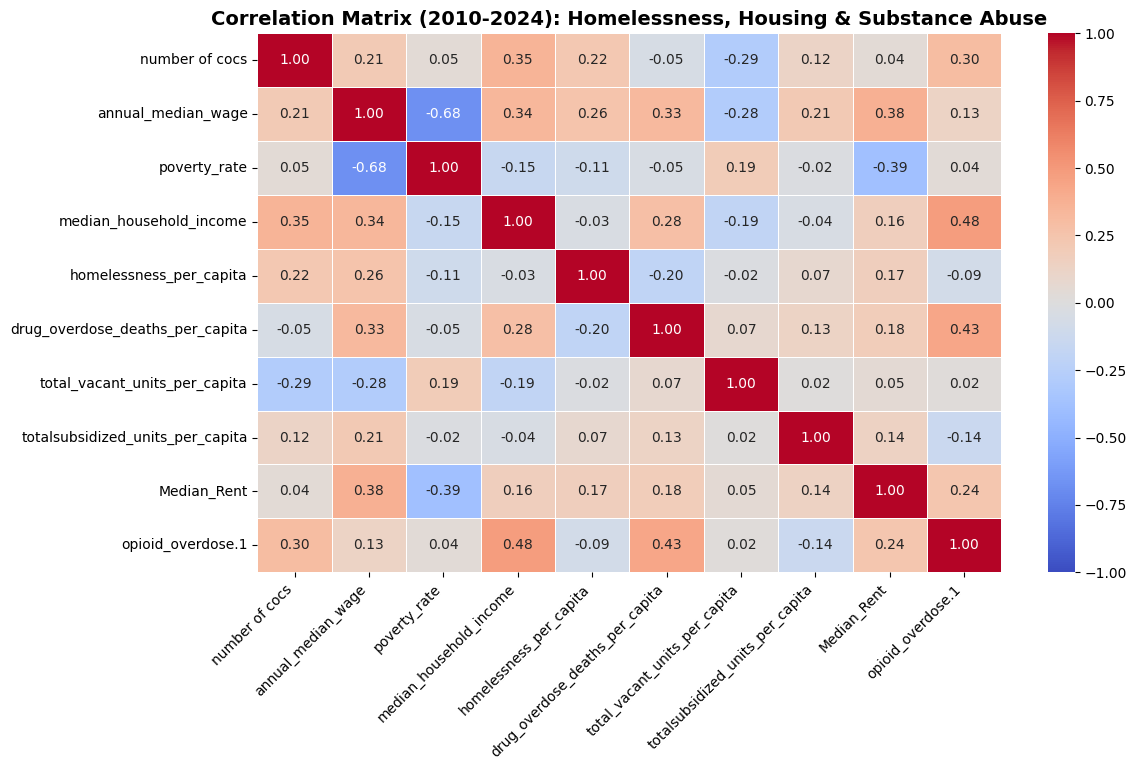

'/Users/rachanathotireddy/Desktop/Project/Plots/multiyear_correlation_matrix_filtered_2010_2024.png'

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "/Users/rachanathotireddy/Desktop/Project/Feature_Data_Per_Capita.csv"  # Change this path to your actual file
df = pd.read_csv(file_path)

# Filter for the years 2010-2024
df_multi_years = df[(df["year"] >= 2010) & (df["year"] <= 2024)]

# Select all columns except 'state' and 'year' for correlation
selected_vars_multi_year = [col for col in df.columns if col not in ["state", "year", "population", "total_households"]]

# Drop rows where any selected variable has missing data for that year
df_cleaned = df_multi_years.dropna(subset=selected_vars_multi_year)

# Compute the correlation matrix for the cleaned data (excluding years with missing data for any variable)
multi_year_correlation_matrix = df_cleaned[selected_vars_multi_year].corr(numeric_only=True)

# Set up an improved heatmap visualization
plt.figure(figsize=(12, 7))
sns.heatmap(
    multi_year_correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    cbar=True,
    vmin=-1, vmax=1  # Ensure the full correlation range is displayed
)

# Titles and Labels
plt.title("Correlation Matrix (2010-2024): Homelessness, Housing & Substance Abuse", fontsize=14, weight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Save the multi-year correlation matrix heatmap
multi_year_correlation_matrix_path = "/Users/rachanathotireddy/Desktop/Project/Plots/multiyear_correlation_matrix_filtered_2010_2024.png"
plt.savefig(multi_year_correlation_matrix_path, dpi=300, bbox_inches="tight")

plt.show()

# Provide the download link for the cleaned multi-year heatmap
multi_year_correlation_matrix_path
